# Garbage Classification with self supervised learning and swin transformer

# basic imports

In [1]:
import numpy as np 
import pandas as pd 
import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, GlobalAveragePooling2D, SeparableConv2D,\
ZeroPadding2D, Convolution2D, ZeroPadding2D, Conv2DTranspose,ReLU, UpSampling2D, Concatenate, Conv2DTranspose

# converting into a dataframe

In [2]:
root='/kaggle/input/d/mostafaabla/garbage-classification/garbage_classification/'
data={}
for i in os.listdir(root):
    for j in os.walk(root+i):
        for k in j[2]:
            data[root+i+'/'+k]=i

In [3]:
data=pd.DataFrame(data.items(),columns=['path','class_'])
data=data.sample(frac=1)
data

,path,class_
11312,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes
807,/kaggle/input/d/mostafaabla/garbage-classifica...,white-glass
11890,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes
4800,/kaggle/input/d/mostafaabla/garbage-classifica...,battery
8589,/kaggle/input/d/mostafaabla/garbage-classifica...,shoes
...,...,...
4049,/kaggle/input/d/mostafaabla/garbage-classifica...,brown-glass
14564,/kaggle/input/d/mostafaabla/garbage-classifica...,plastic
5144,/kaggle/input/d/mostafaabla/garbage-classifica...,trash
2827,/kaggle/input/d/mostafaabla/garbage-classifica...,paper


In [4]:
def split_data(data,ratio):
    last=int(len(data)*ratio)
    return data[:last], data[last:]

In [5]:
train,test=split_data(data,.8)

In [6]:
train.to_csv('train.csv',index=False)
test.to_csv('test.csv',index=False)

# dataset balancing with oversampling

In [7]:
train["class_"].value_counts()

clothes        4285
shoes          1571
paper           836
biological      773
battery         758
cardboard       707
plastic         684
metal           632
white-glass     622
trash           583
green-glass     490
brown-glass     471
Name: class_, dtype: int64

# data dividing

In [8]:
train,valid=split_data(train,.9)

In [9]:
train

,path,class_
11312,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes
807,/kaggle/input/d/mostafaabla/garbage-classifica...,white-glass
11890,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes
4800,/kaggle/input/d/mostafaabla/garbage-classifica...,battery
8589,/kaggle/input/d/mostafaabla/garbage-classifica...,shoes
...,...,...
15079,/kaggle/input/d/mostafaabla/garbage-classifica...,green-glass
13634,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes
9369,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes
5098,/kaggle/input/d/mostafaabla/garbage-classifica...,battery


In [10]:
train["class_"].value_counts()

clothes        3859
shoes          1419
paper           762
biological      701
battery         674
cardboard       631
plastic         613
metal           570
white-glass     548
trash           526
green-glass     444
brown-glass     423
Name: class_, dtype: int64

In [11]:
valid

,path,class_
6862,/kaggle/input/d/mostafaabla/garbage-classifica...,shoes
1447,/kaggle/input/d/mostafaabla/garbage-classifica...,white-glass
6242,/kaggle/input/d/mostafaabla/garbage-classifica...,cardboard
9319,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes
14576,/kaggle/input/d/mostafaabla/garbage-classifica...,plastic
...,...,...
13029,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes
11789,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes
575,/kaggle/input/d/mostafaabla/garbage-classifica...,metal
10289,/kaggle/input/d/mostafaabla/garbage-classifica...,clothes


In [12]:
valid["class_"].value_counts()

clothes        426
shoes          152
battery         84
cardboard       76
white-glass     74
paper           74
biological      72
plastic         71
metal           62
trash           57
brown-glass     48
green-glass     46
Name: class_, dtype: int64

In [13]:
test

,path,class_
888,/kaggle/input/d/mostafaabla/garbage-classifica...,white-glass
2604,/kaggle/input/d/mostafaabla/garbage-classifica...,paper
7280,/kaggle/input/d/mostafaabla/garbage-classifica...,shoes
6528,/kaggle/input/d/mostafaabla/garbage-classifica...,cardboard
3397,/kaggle/input/d/mostafaabla/garbage-classifica...,paper
...,...,...
4049,/kaggle/input/d/mostafaabla/garbage-classifica...,brown-glass
14564,/kaggle/input/d/mostafaabla/garbage-classifica...,plastic
5144,/kaggle/input/d/mostafaabla/garbage-classifica...,trash
2827,/kaggle/input/d/mostafaabla/garbage-classifica...,paper


In [14]:
test["class_"].value_counts()

clothes        1040
shoes           406
paper           214
biological      212
battery         187
cardboard       184
plastic         181
white-glass     153
green-glass     139
metal           137
brown-glass     136
trash           114
Name: class_, dtype: int64

# generators for autoencoder

In [15]:
batch_size = 16
size=224
epoch=50
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='class_',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input"
    )
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col='path',
    y_col='class_',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input"
    )



Found 11170 validated image filenames.
Found 1242 validated image filenames.


# se for encoder

In [16]:
def se_block_enc(inputs,alpha):
    input_channels = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(units=alpha, activation="relu")(x)    
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)    
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x

# defining auto-encoder

In [17]:
# ENCODER
input_img = Input(shape=(size,size, 3))  
x = Conv2D(48, (3, 3), activation='relu', padding='same')(input_img)
x=se_block_enc(x,20)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x=se_block_enc(x,30)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x=se_block_enc(x,50)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Bottolneck
latentSize = (28,28,32)

# DECODER
direct_input = Input(shape=latentSize)
x = Conv2D(192, (1, 1), activation='relu', padding='same')(direct_input)
x = UpSampling2D((2, 2))(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(96, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(48, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(192, (3, 3), activation='relu', padding='same')(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
encoder = Model(input_img, encoded)
decoder = Model(direct_input, decoded)
autoencoder = Model(input_img, decoder(encoded))

In [18]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 48  1344        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 48)          0           ['conv2d[0][0]']                 
 alAveragePooling2D)                                                                        

# complining auto-encoder

In [19]:
autoencoder.compile(optimizer=tf.keras.optimizers.experimental.Adamax(), loss='binary_crossentropy')
history = autoencoder.fit_generator(train_generator,
                                 validation_data= valid_generator,
        epochs = epoch, verbose=2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/50
699/699 - 144s - loss: 0.4792 - val_loss: 0.4691 - 144s/epoch - 206ms/step
Epoch 2/50
699/699 - 126s - loss: 0.4598 - val_loss: 0.4677 - 126s/epoch - 181ms/step
Epoch 3/50
699/699 - 126s - loss: 0.4564 - val_loss: 0.4607 - 126s/epoch - 180ms/step
Epoch 4/50
699/699 - 126s - loss: 0.4550 - val_loss: 0.4595 - 126s/epoch - 180ms/step
Epoch 5/50
699/699 - 126s - loss: 0.4540 - val_loss: 0.4584 - 126s/epoch - 181ms/step
Epoch 6/50
699/699 - 126s - loss: 0.4530 - val_loss: 0.4592 - 126s/epoch - 180ms/step
Epoch 7/50
699/699 - 126s - loss: 0.4525 - val_loss: 0.4573 - 126s/epoch - 180ms/step
Epoch 8/50
699/699 - 126s - loss: 0.4517 - val_loss: 0.4568 - 126s/epoch - 181ms/step
Epoch 9/50
699/699 - 126s - loss: 0.4512 - val_loss: 0.4572 - 126s/epoch - 180ms/step
Epoch 10/50
699/699 - 126s - loss: 0.4508 - val_loss: 0.4572 - 126s/epoch - 180ms/step
Epoch 11/50
699/699 - 126s - loss: 0.4508 - val_loss: 0.4559 - 126s/epoch - 180ms/step
Epoch 12/50
699/699 - 126s - loss: 0.4503 - val_loss

# auto-encoder loss graph

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.
  if sys.path[0] == "":


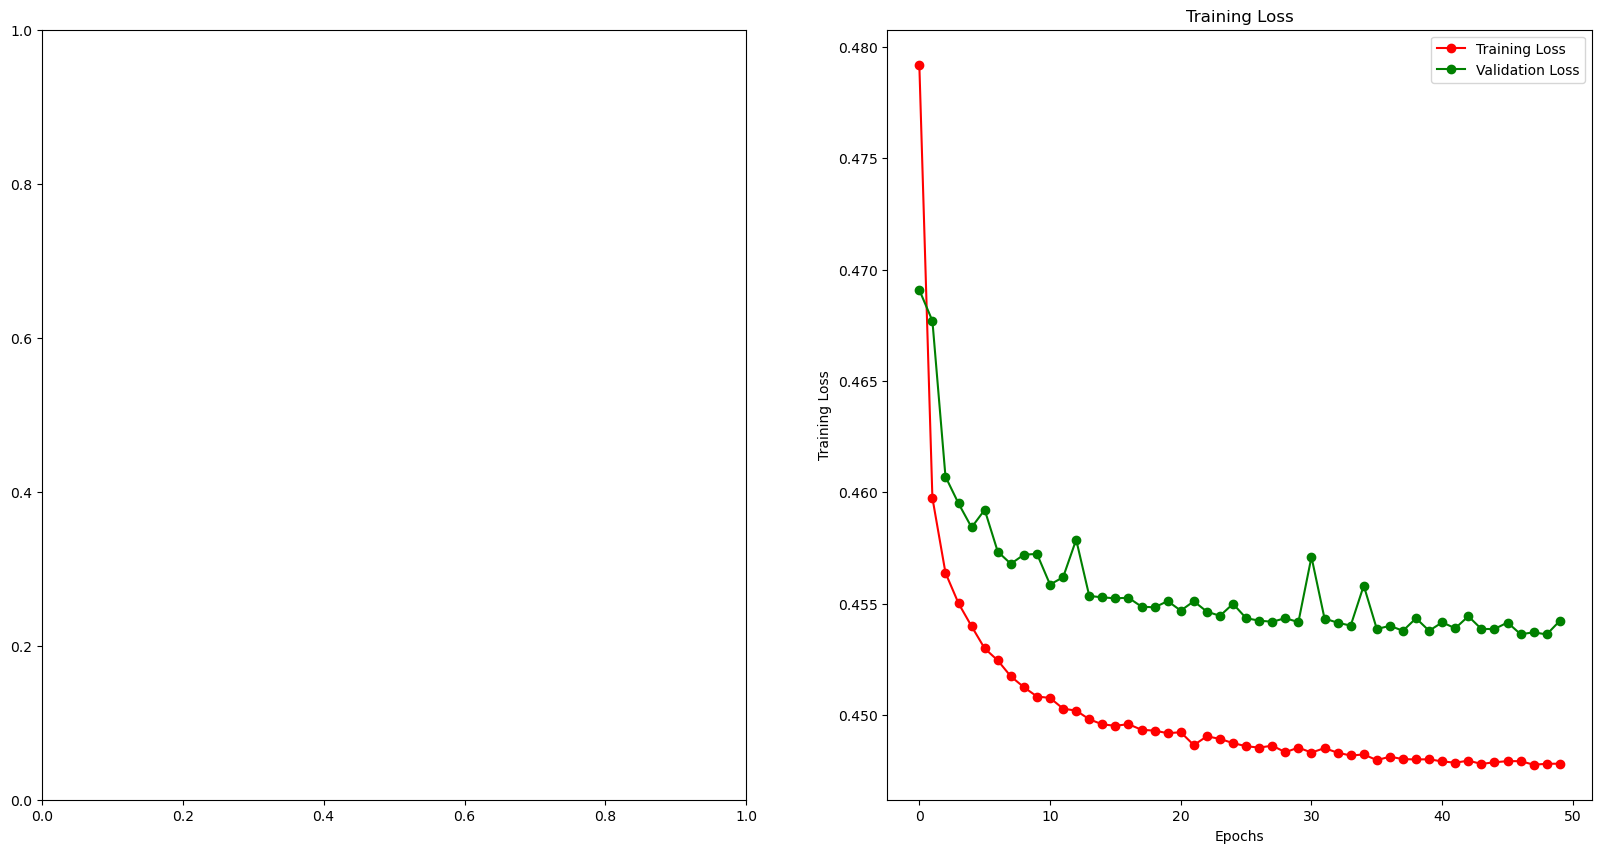

In [20]:
epochs = list(range(len(history.history['loss'])))
fig , ax = plt.subplots(1,2)

train_loss = history.history['loss']

val_loss = history.history['val_loss']

fig.set_size_inches(20,10)



ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

# saving model

In [21]:
autoencoder.save("auto_encoder.h5")
encoder.save('encoder.h5')
decoder.save('decoder.h5')

# checking the performance of auto-encoder

1/1 [==============================] - 0s 238ms/step


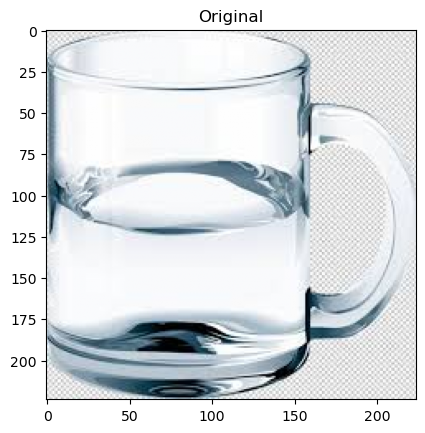

In [22]:
orig = cv2.imread(test.iloc[0]['path']) 
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
orig=orig* 1.0 / 255.0
orig = cv2.resize(orig, (size, size),
               interpolation = cv2.INTER_NEAREST)
img = tf.expand_dims(orig, axis=0)

encoder_output=encoder.predict(img)
plt.title('Original')
plt.imshow(orig)

In [23]:
encoder_output.shape

(1, 28, 28, 32)

Text(0.5, 1.0, 'a samplt output of encoded image')

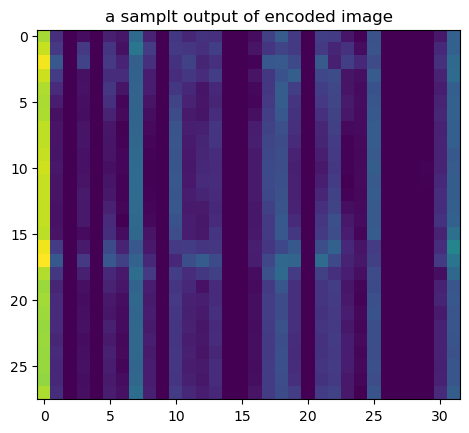

In [24]:
plt.imshow(encoder_output[0][0]) # a channel output shown in plot
plt.title("a samplt output of encoded image")

In [25]:
original_output=decoder.predict(encoder_output)

1/1 [==============================] - 0s 287ms/step


Text(0.5, 1.0, 'reconstructed image')

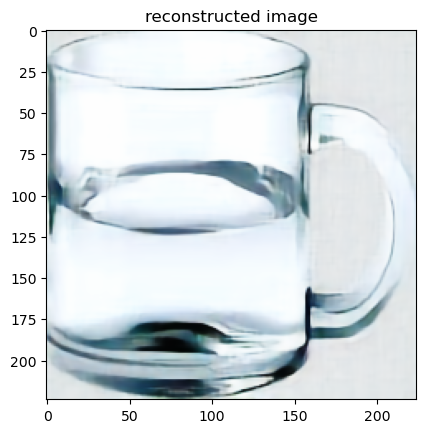

In [26]:
plt.imshow(original_output[0])
plt.title("reconstructed image")

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_images = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)
valid_images=valid_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col='path',
    y_col='class_',
    batch_size=batch_size,
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    seed=42,
)

Found 11170 validated image filenames belonging to 12 classes.
Found 1242 validated image filenames belonging to 12 classes.


# freezing encoder

In [28]:
for i in encoder.layers:
    i.freeze=True

# basic functions

In [29]:
import tensorflow_hub as hub
def get_from_hub(model_url):
    inputs = tf.keras.Input((224, 224, 3))
    hub_module = hub.KerasLayer(model_url,trainable=False)
    outputs = hub_module(inputs)
    return tf.keras.Model(inputs, outputs)

In [30]:
def se_block(inputs):
    input_channels = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(units=len(train_images.class_indices.keys()), activation="relu")(x)    
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)    
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x

In [31]:
swin=get_from_hub('https://tfhub.dev/sayakpaul/swin_large_patch4_window7_224_in22k_fe/1')

# fine tuning swin transformer

In [32]:
from tensorflow.keras import regularizers
x=swin.output
x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(32, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dense(256,activation='relu')(x)
x_swin = Dense(128, activation='relu')(x)

# fine tunine encoder

In [33]:
def get_model(base_model):
    x = tf.keras.layers.GlobalAveragePooling2D()(se_block(base_model.output))
    x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dense(256,activation='relu')(x)
    return Dense(128,activation='relu')(x)

In [34]:
x_encoder=get_model(encoder)

# final model

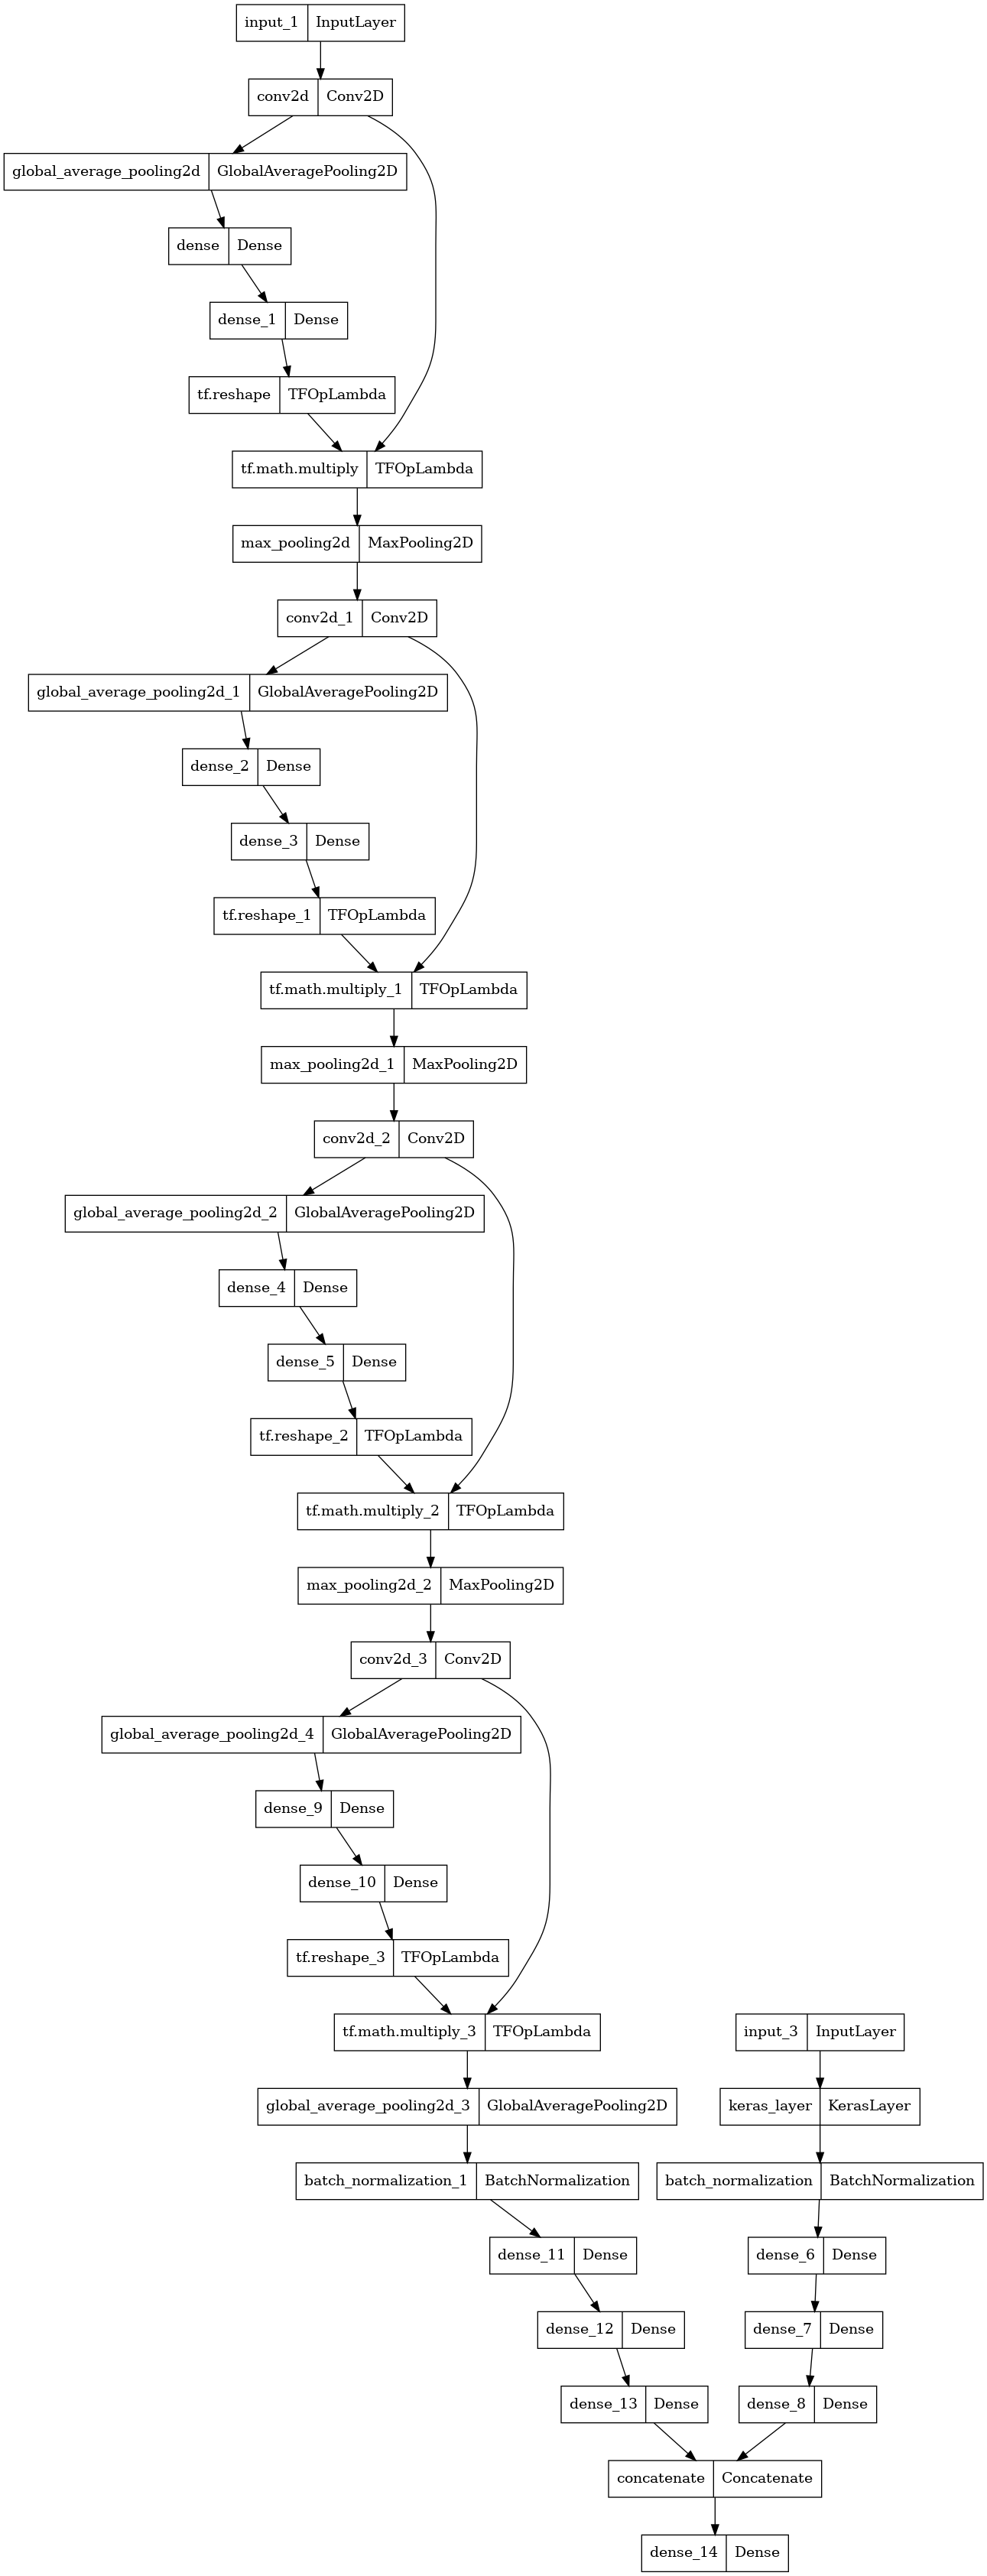

In [35]:
from tensorflow.keras.layers import concatenate
concatenated=concatenate([x_encoder,x_swin])
bigmodel_prediction = Dense(len(train_images.class_indices), activation='softmax')(concatenated)
model = Model([encoder.input,swin.input], bigmodel_prediction)
from tensorflow.keras.utils import plot_model
plot_model(model)

In [36]:
trainable_params = sum([v.numpy().size for v in model.trainable_variables])
non_trainable_params = sum([v.numpy().size for v in model.non_trainable_variables])
print("trainable parametres: "+ str(trainable_params) + " non trainable parametres: "+ str(non_trainable_params))

trainable parametres: 521164 non trainable parametres: 194998612


# generators for actual model

In [37]:
def generator_two_img(gen):
    while True:
        X1i = gen.next()
        yield [X1i[0],X1i[0]], X1i[1]

# training model

In [38]:
model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.experimental.Adamax(),metrics=['accuracy'])

In [39]:
history = model.fit(
    generator_two_img(train_images),
    validation_data=generator_two_img(valid_images), 
    validation_steps=valid_images.n//batch_size,
    validation_batch_size=batch_size,
    steps_per_epoch=train_generator.n//batch_size,
    batch_size=batch_size,
    epochs=epoch,
)

Epoch 1/50
698/698 [==============================] - 346s 456ms/step - loss: 1.1393 - accuracy: 0.9016 - val_loss: 0.6080 - val_accuracy: 0.9675
Epoch 2/50
698/698 [==============================] - 314s 450ms/step - loss: 0.4995 - accuracy: 0.9699 - val_loss: 0.4078 - val_accuracy: 0.9732
Epoch 3/50
698/698 [==============================] - 300s 430ms/step - loss: 0.3409 - accuracy: 0.9793 - val_loss: 0.3049 - val_accuracy: 0.9781
Epoch 4/50
698/698 [==============================] - 315s 452ms/step - loss: 0.2572 - accuracy: 0.9808 - val_loss: 0.2498 - val_accuracy: 0.9756
Epoch 5/50
698/698 [==============================] - 300s 430ms/step - loss: 0.2122 - accuracy: 0.9817 - val_loss: 0.2233 - val_accuracy: 0.9797
Epoch 6/50
698/698 [==============================] - 301s 432ms/step - loss: 0.1815 - accuracy: 0.9832 - val_loss: 0.2130 - val_accuracy: 0.9765
Epoch 7/50
698/698 [==============================] - 314s 450ms/step - loss: 0.1609 - accuracy: 0.9836 - val_loss: 0.1961 -

In [40]:
model.save('model.h5')

# performance evaluation

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.


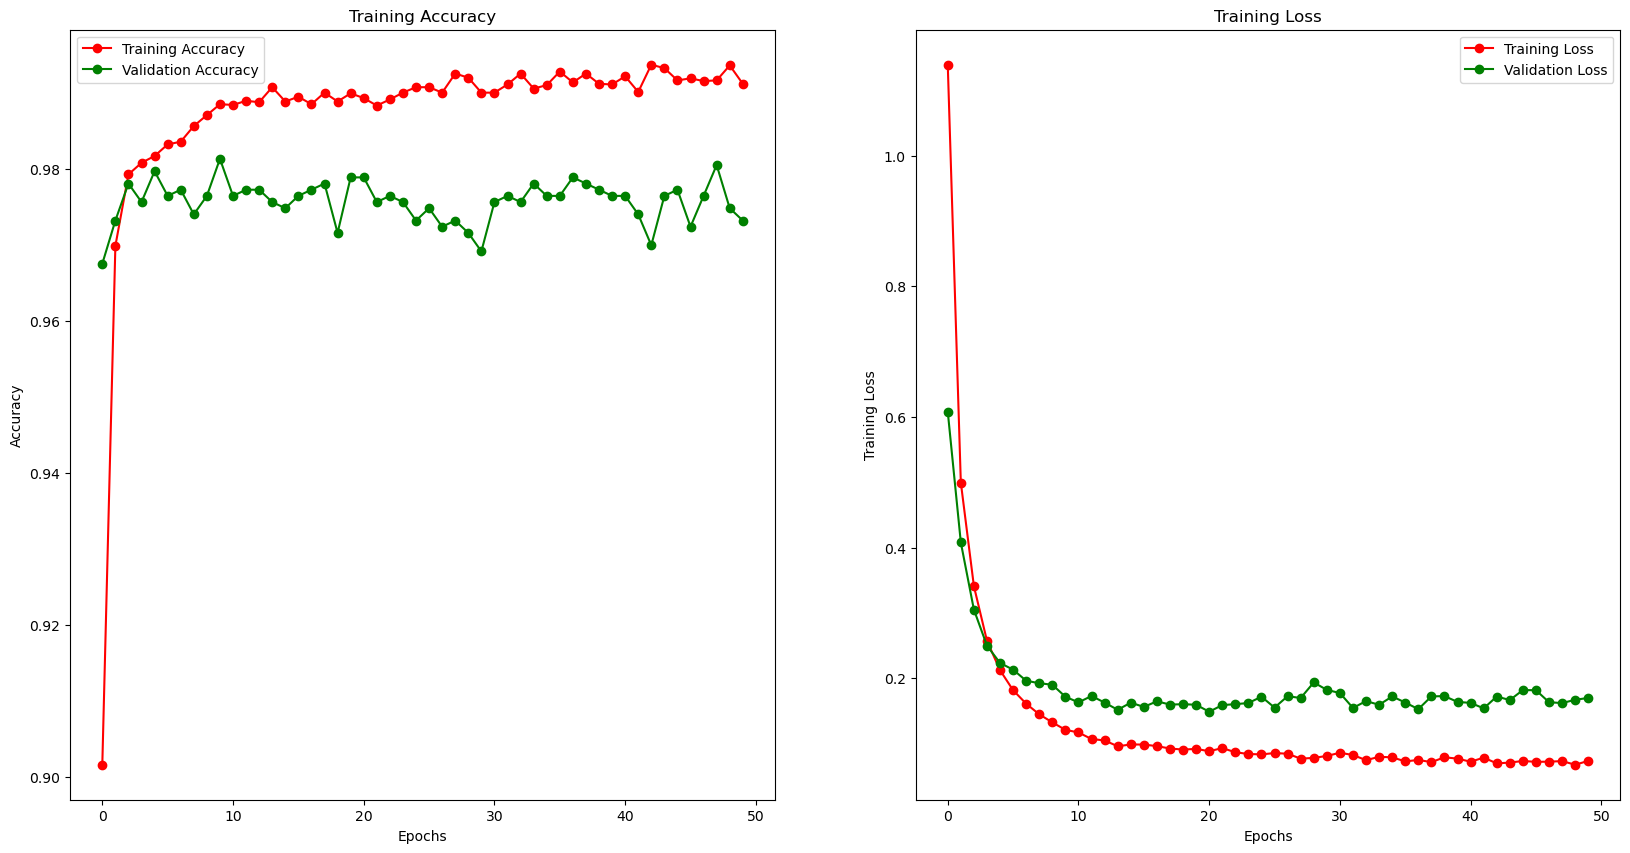

In [41]:
epochs = list(range(len(history.history['accuracy'])))
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' ,color='r', label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'go-' , label = 'Validation Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs , train_loss , 'g-o' ,color='r', label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'go-' , label = 'Validation Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training Loss")
plt.show()

# test datagen

In [42]:
class_=train_images.class_indices.keys()

In [43]:
test_generator = ImageDataGenerator(
    rescale=1.0 / 255,
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='path',
    y_col='class_',
    target_size=(size, size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    subset='training'
)

Found 3103 validated image filenames belonging to 12 classes.


In [44]:
def prediction_generator(test_images):
    k=0
    for x in test_images:
        k+=len(x[1])
        yield [x[0],x[0]], x[1]
        if(k>=test_images.n):
            break

In [45]:
from sklearn.metrics import accuracy_score
proba=model.predict(prediction_generator(test_images))
predicted = np.argmax(proba,axis=1)
true=test_images.labels
accuracy_score(predicted, true)

194/194 [==============================] - 72s 354ms/step


0.9777634547212375

# confusion matrix

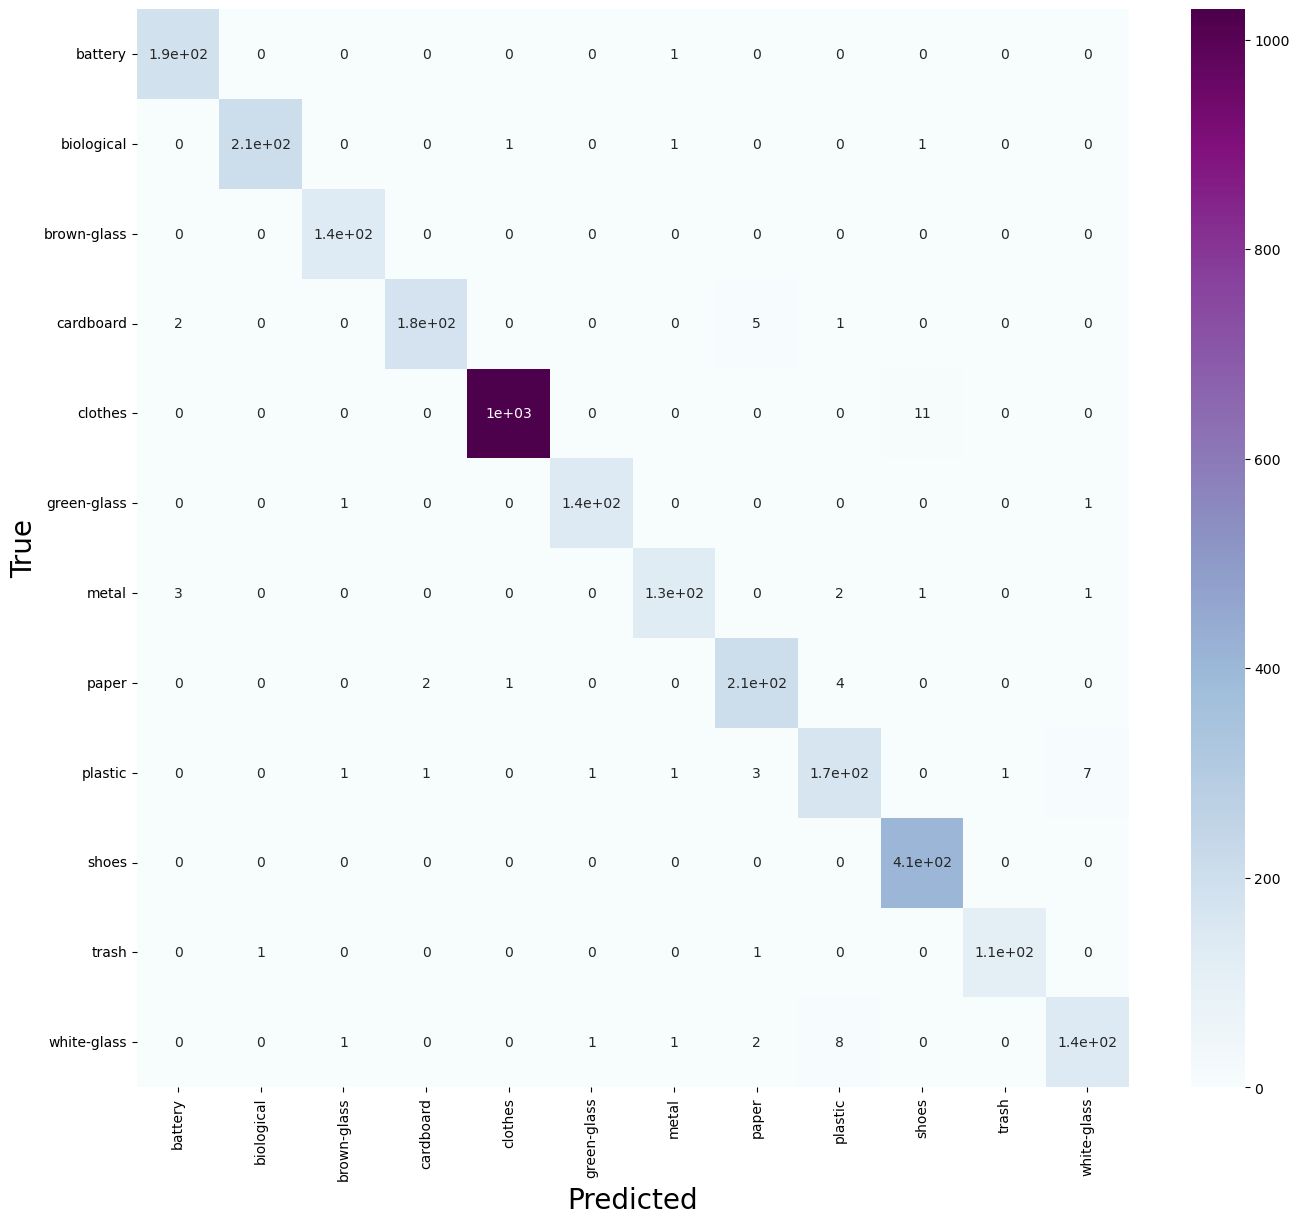

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_=test_images.class_indices.keys()
cm = confusion_matrix(true, predicted)
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="BuPu"); 
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_, fontsize = 10)
plt.yticks(rotation=0)

plt.title('', fontsize=60)

plt.savefig('ConMat24.png')
plt.show()

# ROC

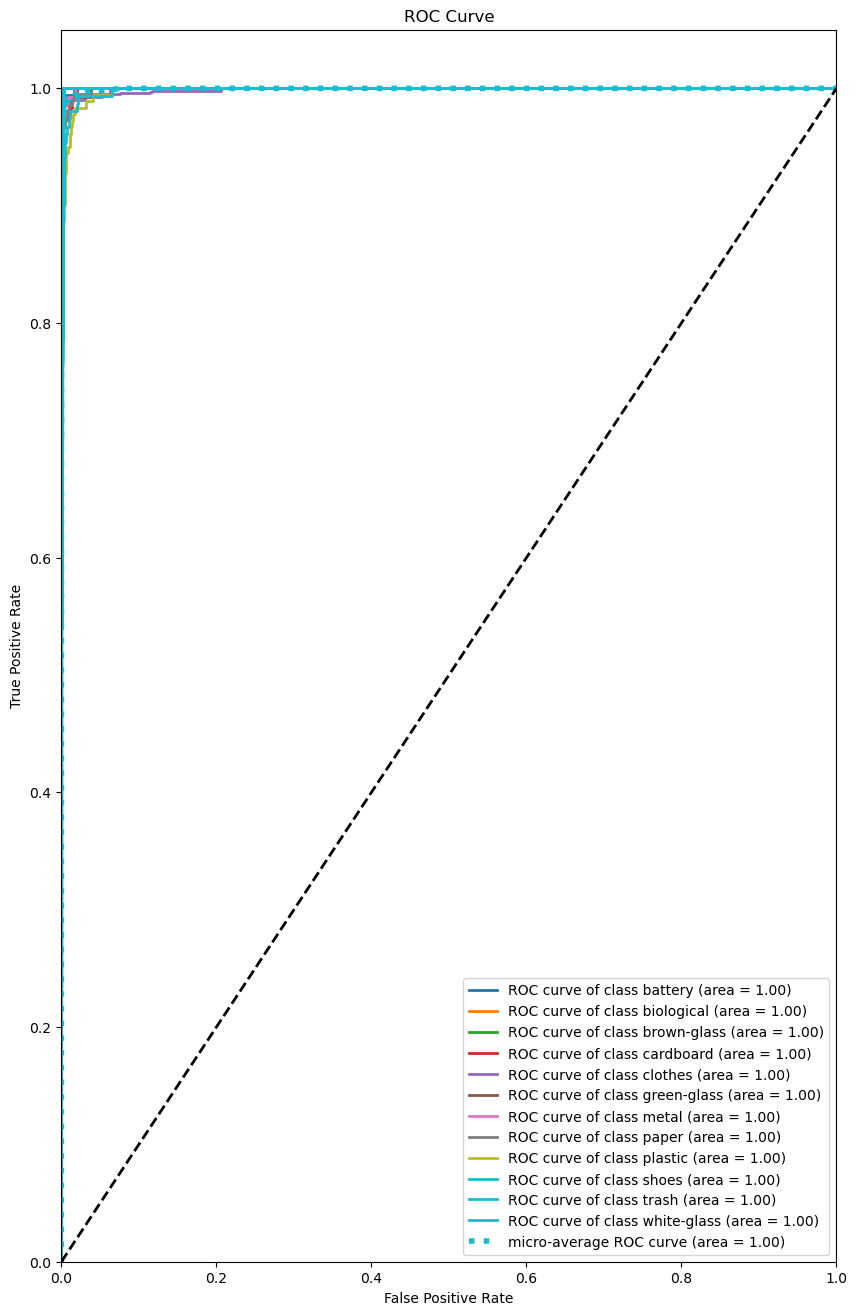

In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import cm
n=len(true)
dim=max(true)+1
result=[]
for i in true:
    result.append([0 for i in range(dim)])
    result[len(result)-1][i]=1
    
    
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes =len(test_images.class_indices.keys())
y_test=np.array(result)
y_pred=np.array(proba)
fpr = dict()
tpr = dict()
roc_auc = dict()

rev={}
for i in class_:
    rev[train_images.class_indices[i]]=i


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = roc_auc_score(y_test, y_pred, multi_class='ovr')


cmap = cm.get_cmap('tab10')

# Plot the ROC curve for each class and micro-average with automatic color selection
plt.figure(figsize=(10,16))
lw = 2
for i in range(n_classes):
    color = cmap(i)
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(rev[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color=cmap(n_classes), linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# AUC

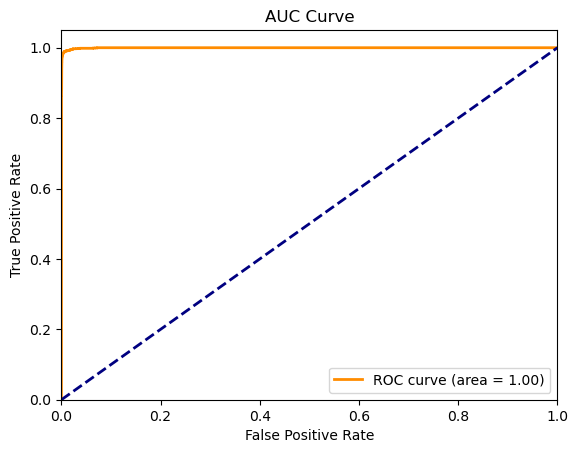

In [48]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_true=y_test
y_score=y_pred
fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc="lower right")
plt.show()